In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import anndata as ad 
import scanpy as sc
sys.path.append("../../")
import utils
from sklearn.decomposition import PCA
import umap
import graph
import visualize

In [9]:
## read in all the stuff

cnngnn_embed = np.load("/home/bkzhu/spatial_clustering/phase3/spatial-clust-scripts-main/data/hubmap/Embedding_train01/B009_Duodenum/gnncnn_embedding_epoch500_l2.npy")
train_mask = np.load("/home/bkzhu/spatial_clustering/phase3/spatial-clust-scripts-main/data/hubmap/Embedding_train01/B009_Duodenum/train_mask.npy")
df = pd.read_csv('/home/bkzhu/spatial_clustering/phase2/data/hubmap/B009A.csv', index_col=0)
df = df.loc[df["Tissue_location"] == "Duodenum",:]
gnn_embed = np.load('/home/bkzhu/spatial_clustering/phase3/spatial-clust-scripts-main/data/hubmap/Embedding_train01/B009_Duodenum/gnn_embedding.npy')

In [13]:
df.columns[1:48]

Index(['MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15', 'CHGA',
       'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR', 'CD8', 'CD11c',
       'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38', 'CD90', 'aSMA', 'CD21',
       'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68', 'CD34', 'aDef5', 'CD7',
       'CD36', 'CD138', 'CD45RO', 'Cytokeratin', 'CD117', 'CD19', 'Podoplanin',
       'CD45', 'CD56', 'CD69', 'Ki67', 'CD49a', 'CD163', 'CD161'],
      dtype='object')

In [14]:
# get train masked cells
cnngnn_embed_sub = cnngnn_embed[train_mask,:]
features_sub = df.iloc[train_mask,1:48].to_numpy()
gnn_embed_sub = gnn_embed[train_mask,:]

# then we get 10k sub set cells for testing
indices = np.random.choice(cnngnn_embed_sub.shape[0], 10000, replace=False)
cnngnn_embed_sub = cnngnn_embed_sub[indices]
features_sub = features_sub[indices]
gnn_embed_sub = gnn_embed_sub[indices]

No handles with labels found to put in legend.


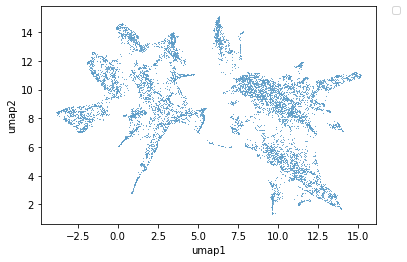

In [15]:
# protein only

features = features_sub
features_after_pca = features # for consistency, no pca done
umap_fit = umap.UMAP(random_state=42)
umap_embed_feature = umap_fit.fit_transform(features_after_pca)

# plot out
umap_embed_feature_df = pd.DataFrame(umap_embed_feature, columns = ['umap1', 'umap2'])
#umap_embed_feature_df['type'] = df['cluster.term'].values[indices]
#sns.scatterplot(data=umap_embed_feature_df, x='umap1', y='umap2', hue='type', s=1)
sns.scatterplot(data=umap_embed_feature_df, x='umap1', y='umap2', s=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

No handles with labels found to put in legend.


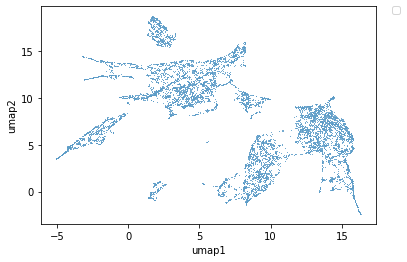

In [16]:
# vanilla gnn

gnn_after_pca = gnn_embed_sub
umap_fit = umap.UMAP(random_state=42)
umap_embed_gnn = umap_fit.fit_transform(gnn_after_pca)

# plot out
umap_embed_gnn_df = pd.DataFrame(umap_embed_gnn, columns = ['umap1', 'umap2'])
#umap_embed_gnn_df['type'] = df['cluster.term'].values[indices]
#sns.scatterplot(data=umap_embed_gnn_df, x='umap1', y='umap2', hue='type', s=1)
sns.scatterplot(data=umap_embed_gnn_df, x='umap1', y='umap2', s=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

No handles with labels found to put in legend.


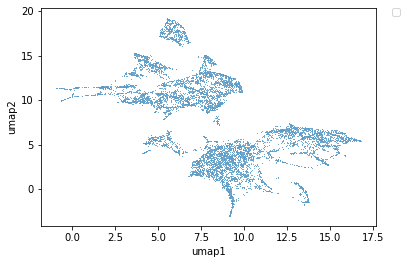

In [17]:
# convgnn

convgnn_after_pca = cnngnn_embed_sub
umap_fit = umap.UMAP(random_state=42)
umap_embed_convgnn = umap_fit.fit_transform(convgnn_after_pca)

# plot out
umap_embed_convgnn_df = pd.DataFrame(umap_embed_convgnn, columns = ['umap1', 'umap2'])
#umap_embed_convgnn_df['type'] = df['cluster.term'].values[indices]
#sns.scatterplot(data=umap_embed_convgnn_df, x='umap1', y='umap2', hue='type', s=1)
sns.scatterplot(data=umap_embed_convgnn_df, x='umap1', y='umap2', s=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [24]:
import sklearn.metrics

feature_ss_list = []
gnn_ss_list = []
covgnn_ss_list = []
k_clusters = [x for x in range(10,35,2)]

for k in k_clusters:
    
    ## feature only
    feature_edges = graph.get_feature_edges(
        arr=features_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )
    feature_labels = graph.graph_clustering(
        features_sub.shape[0], feature_edges, resolution=None, n_clusters=k, n_runs=1,
        resolution_tol=0.05, seed=None, verbose=False
    )
    
    ## gnn only
    feature_edges_gnn = graph.get_feature_edges(
        arr=gnn_embed_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )
    feature_labels_gnn = graph.graph_clustering(
        gnn_embed_sub.shape[0], feature_edges_gnn, resolution=None, n_clusters=k, n_runs=1,
        resolution_tol=0.05, seed=None, verbose=False
    )
    
    ## convGNN 
    feature_edges_conv = graph.get_feature_edges(
        arr=cnngnn_embed_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )
    feature_labels_conv = graph.graph_clustering(
        cnngnn_embed_sub.shape[0], feature_edges_conv, resolution=None, n_clusters=k, n_runs=1,
        resolution_tol=0.05, seed=None, verbose=False
    )
    
    feature_ss = sklearn.metrics.silhouette_score(umap_embed_feature, feature_labels)
    gnn_ss = sklearn.metrics.silhouette_score(umap_embed_gnn, feature_labels_gnn)
    covgnn_ss = sklearn.metrics.silhouette_score(umap_embed_convgnn, feature_labels_conv)
    
    feature_ss_list.append(feature_ss)
    gnn_ss_list.append(gnn_ss)
    covgnn_ss_list.append(covgnn_ss)
    

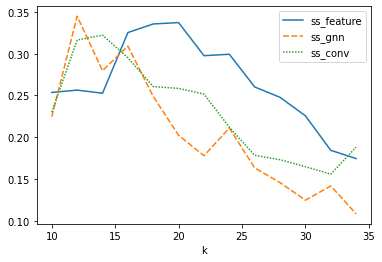

In [25]:
data = {'k':k_clusters, 'ss_feature':feature_ss_list, 'ss_gnn':gnn_ss_list,'ss_conv':covgnn_ss_list}
#data = {'k':k_clusters, 'ss_feature':feature_ss_list, 'ss_gnn':gnn_ss_list}

df = pd.DataFrame(data)
df = df.set_index('k')

sns.lineplot(data=df)

In [20]:
import leidenalg
import igraph as ig

def get_modularity(n,edges, seed = 42, resolution = 1):
    
    g = ig.Graph(directed=True)
    g.add_vertices(n)
    g.add_edges(list(zip(edges[0], edges[1])))
    g.es['weight'] = tuple(edges[2])
    partition_kwargs = {'n_iterations': -1, 'seed': seed,
                    'resolution_parameter': resolution}
    partition_kwargs['weights'] = np.array(g.es['weight']).astype(np.float64)
    partition_type = leidenalg.RBConfigurationVertexPartition
    curr_part = leidenalg.find_partition(
                graph=g, partition_type=partition_type,
                **partition_kwargs
            )
    curr_modularity = curr_part.modularity
    
    return curr_modularity

In [21]:
feature_md_list = []
gnn_md_list = []
covgnn_md_list = []
res_list = [round(x, 2) for x in np.arange (0.1, 2.5, 0.2)]

for res in res_list:
    
    feature_md = get_modularity(features_sub.shape[0], feature_edges, resolution = res)
    gnn_md = get_modularity(features_sub.shape[0], feature_edges_gnn, resolution = res)
    covgnn_md = get_modularity(features_sub.shape[0], feature_edges_conv, resolution = res)

    feature_md_list.append(feature_md)
    gnn_md_list.append(gnn_md)
    covgnn_md_list.append(covgnn_md)
    

In [22]:
data2 = {'res':res_list, 'md_feature':feature_md_list, 'md_gnn':gnn_md_list,'md_conv':covgnn_md_list}
#data2 = {'res':res_list, 'md_feature':feature_md_list, 'md_gnn':gnn_md_list}

df2 = pd.DataFrame(data2)
df2 = df2.set_index('res')
df2

,md_feature,md_gnn,md_conv
res,,,
0.1,0.738638,0.768120,0.715087
0.3,0.843004,0.840623,0.810193
0.5,0.855542,0.849393,0.826945
0.7,0.853958,0.859960,0.836233
0.9,0.855327,0.858385,0.835372
1.1,0.853568,0.855862,0.834082
1.3,0.848563,0.851627,0.829171
1.5,0.842145,0.848408,0.826580
1.7,0.843364,0.843488,0.822354


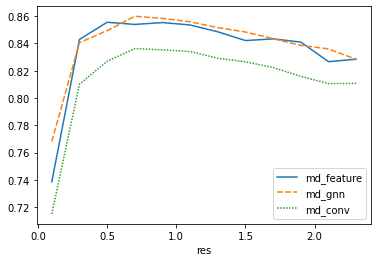

In [23]:
sns.lineplot(data=df2)